# Vấn đề bài toán:
    Dự báo sự tăng hoặc giảm giá cổ phiếu lúc đóng phiên vào hôm sau của Amazon (2015-2022)
    
- Xây dựng các đặc trưng mới để dự báo với sự tăng giá hay giảm của cổ phiếu Amazon

- Lựa chọn model Logistic regression và Random Forest Classifier cho việc lựa chọn và đánh giá mô hình dự báo

- Phân chia tập dữ liệu train và test để đánh giá độ hiểu quả

### Trích xuất đặc trưng

    Import thư viện

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform
from sklearn.metrics import accuracy_score, confusion_matrix
sns.set_theme(style='darkgrid')
import warnings
warnings.filterwarnings('ignore')

    Đọc dữ liệu được làm sạch từ file clean_data.csv

In [34]:
data = pd.read_csv('./clean data/clean_data.csv')
data

,Date,Open,High,Low,Close,Volume
0,Jan 11 2021,157.40,157.82,155.50,155.71,73668000
1,Jan 12 2021,156.00,157.11,154.30,156.04,70292000
2,Jan 13 2021,156.42,159.50,156.10,158.29,66424000
3,Jan 14 2021,158.38,158.90,156.03,156.37,61418000
4,Jan 15 2021,156.15,157.13,154.76,155.21,84880000
...,...,...,...,...,...,...
960,Nov 4 2024,196.45,197.33,194.31,195.78,38492100
961,Nov 5 2024,196.04,199.82,195.99,199.50,30564800
962,Nov 6 2024,200.01,207.55,199.14,207.09,72292200
963,Nov 7 2024,207.44,212.25,207.19,210.05,52878400


    Tạo thêm các đặc trưng mới cho bộ dữ liệu

    'Have_Increase' - Giá trị tăng trưởng của cổ phiếu

+ Nếu giá mở cửa trừ giá đóng cửa < 0 -> giá trị sẽ bằng 0

+ Nếu giá mở cửa trừ giá đóng cửa > 0 -> giá trị sẽ bằng 1

In [35]:
conditions = [(data['Open'] - data['Close']) < 0, (data['Open'] - data['Close']) > 0]
values = [0, 1]
data['Have_Increase'] = np.select(conditions, values, default = 1)
data.head()

,Date,Open,High,Low,Close,Volume,Have_Increase
0,Jan 11 2021,157.40,157.82,155.50,155.71,73668000,1
1,Jan 12 2021,156.00,157.11,154.30,156.04,70292000,0
2,Jan 13 2021,156.42,159.50,156.10,158.29,66424000,0
3,Jan 14 2021,158.38,158.90,156.03,156.37,61418000,1
4,Jan 15 2021,156.15,157.13,154.76,155.21,84880000,1


    'Target' - So sánh giá trị đóng phiên trước và phiên sau

+ Nếu giá trị đóng ngày sau > giá trị đóng ngày trước -> giá trị sẽ bằng 1

+ Nếu giá trị đóng ngày sau < giá trị đóng ngày trước -> giá trị sẽ bằng 0

In [36]:
newfeatures = pd.DataFrame()
newfeatures['Target'] = data["Close"].rolling(window=2).apply(lambda x: x.iloc[1] > x.iloc[0])
newfeatures['Target'].fillna(0, inplace=True)
newfeatures.head()


,Target
0,0.0
1,1.0
2,1.0
3,0.0
4,0.0


In [37]:
data = data.shift(1)
data['Target'] = newfeatures['Target']
data = data.iloc[1:]
data.head()

,Date,Open,High,Low,Close,Volume,Have_Increase,Target
1,Jan 11 2021,157.40,157.82,155.50,155.71,73668000.0,1.0,1.0
2,Jan 12 2021,156.00,157.11,154.30,156.04,70292000.0,0.0,1.0
3,Jan 13 2021,156.42,159.50,156.10,158.29,66424000.0,0.0,0.0
4,Jan 14 2021,158.38,158.90,156.03,156.37,61418000.0,1.0,0.0
5,Jan 15 2021,156.15,157.13,154.76,155.21,84880000.0,1.0,1.0


    Rolling means
- Đại lượng thể hiện tương quan giữa giá cổ phiếu hiện tại với giá cổ phiếu trung bình trong tuần, quý hoặc năm
- Nếu giá hiện tại cao hơn giá hàng năm thì nghĩa là cố phiếu đang có xu hướng tăng

    Sử dụng phương pháp rolling để tìm ra mean của cột Close với số ngày khác nhau (tuần, quý, năm)

In [38]:
weekly_mean = data['Close'].rolling(window=7).mean()
quarterly_mean = data['Close'].rolling(window=90).mean()
annual_mean = data['Close'].rolling(window=365).mean()

    Tỉ số giữa weekly_mean, quarterly_mean, annual_mean với cột Close

In [39]:
data['weekly_mean'] = weekly_mean / data['Close']
data['quarterly_mean'] = quarterly_mean / data['Close']
data['annual_mean'] = annual_mean / data['Close']

    Thêm tỉ số giữa giá mở cửa, giá cao, giá thấp và giá đóng cửa trong ngày. 
    
    Ví dụ : Nếu giá cao > giá đóng cửa -> cổ phiếu có xu hướng giảm vào cuối ngày.

In [40]:
data['open_close_ratio'] = data['Open'] / data['Close']
data['high_close_ratio'] = data['High'] / data['Close']
data['low_close_ratio'] = data['Low'] / data['Close']

    Dữ liệu sau khi được thêm mới

In [41]:
data.head()

,Date,Open,High,Low,Close,Volume,Have_Increase,Target,weekly_mean,quarterly_mean,annual_mean,open_close_ratio,high_close_ratio,low_close_ratio
1,Jan 11 2021,157.40,157.82,155.50,155.71,73668000.0,1.0,1.0,NaN,NaN,NaN,1.010854,1.013551,0.998651
2,Jan 12 2021,156.00,157.11,154.30,156.04,70292000.0,0.0,1.0,NaN,NaN,NaN,0.999744,1.006857,0.988849
3,Jan 13 2021,156.42,159.50,156.10,158.29,66424000.0,0.0,0.0,NaN,NaN,NaN,0.988186,1.007644,0.986165
4,Jan 14 2021,158.38,158.90,156.03,156.37,61418000.0,1.0,0.0,NaN,NaN,NaN,1.012854,1.016180,0.997826
5,Jan 15 2021,156.15,157.13,154.76,155.21,84880000.0,1.0,1.0,NaN,NaN,NaN,1.006056,1.012370,0.997101


    Biểu diễn đồ thị của các giá trị trung bình hàng tuần, hàng quý và hàng năm

Text(0.5, 1.0, 'Đồ thị của các giá trị trung bình hàng tuần, hàng quý và hàng năm khi chưa xử lý dữ liệu trống')

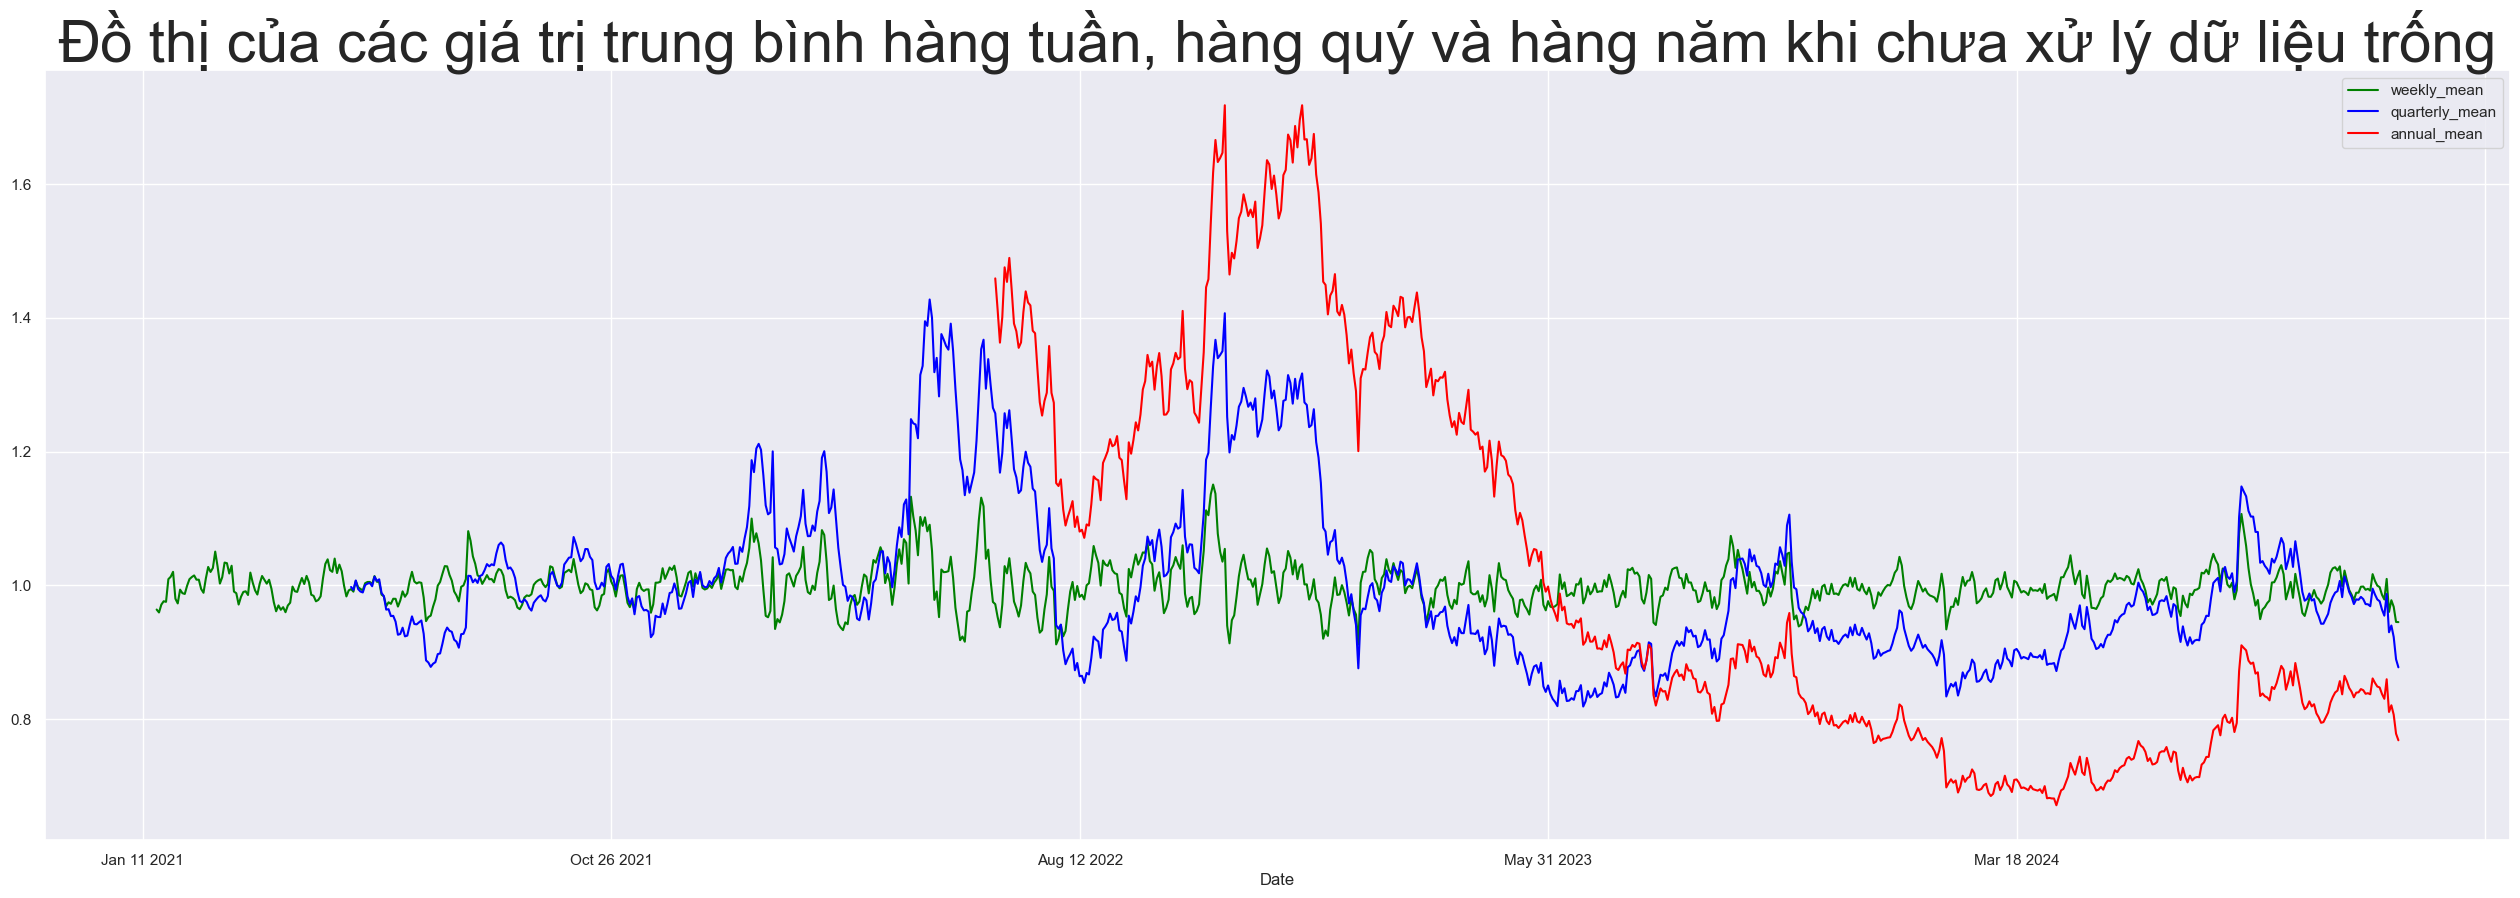

In [42]:
plt.figure(figsize=(70,10))
ax1 = plt.subplot(1, 2, 1)
data.plot.line(x='Date', y='weekly_mean', ax = ax1, color='green', label='weekly_mean')
data.plot.line(x='Date', y='quarterly_mean',ax = ax1, color='blue', label='quarterly_mean')
data.plot.line(x='Date', y='annual_mean',ax = ax1, color='red', label='annual_mean')
plt.title("Đồ thị của các giá trị trung bình hàng tuần, hàng quý và hàng năm khi chưa xử lý dữ liệu trống", fontsize=42)

    Ta thấy dữ liệu trống nhiều. Việc tiếp theo ta cần phải xử lý dữ liệu trống
    
    Lựa chon random sample để có thể giữ được độ chính xác của dữ liệu mà tránh làm dữ liệu bị mất đi những đặc trưng 


    Tạo hàm Random Sample

In [43]:
def random_sample(columname):
    last_index_null = data[columname].isnull().sum()
    random_sample = data[columname][last_index_null:last_index_null*2].sample(n=last_index_null,random_state=0)
    random_sample.index = data[data[columname].isnull()].index
    data[columname].update(random_sample) 

In [44]:
random_sample('weekly_mean')
random_sample('quarterly_mean')
random_sample('annual_mean')
data.head()

,Date,Open,High,Low,Close,Volume,Have_Increase,Target,weekly_mean,quarterly_mean,annual_mean,open_close_ratio,high_close_ratio,low_close_ratio
1,Jan 11 2021,157.40,157.82,155.50,155.71,73668000.0,1.0,1.0,1.009192,1.007248,0.797293,1.010854,1.013551,0.998651
2,Jan 12 2021,156.00,157.11,154.30,156.04,70292000.0,0.0,1.0,0.971161,0.988565,0.905715,0.999744,1.006857,0.988849
3,Jan 13 2021,156.42,159.50,156.10,158.29,66424000.0,0.0,0.0,0.959411,1.008916,1.127231,0.988186,1.007644,0.986165
4,Jan 14 2021,158.38,158.90,156.03,156.37,61418000.0,1.0,0.0,0.976190,0.936829,1.152819,1.012854,1.016180,0.997826
5,Jan 15 2021,156.15,157.13,154.76,155.21,84880000.0,1.0,1.0,0.963789,1.037739,1.165478,1.006056,1.012370,0.997101


    Biểu diễn đồ thị

Text(0.5, 1.0, 'Đồ thị của các giá trị trung bình hàng tuần, hàng quý và hàng năm khi đã xử lý dữ liệu trống')

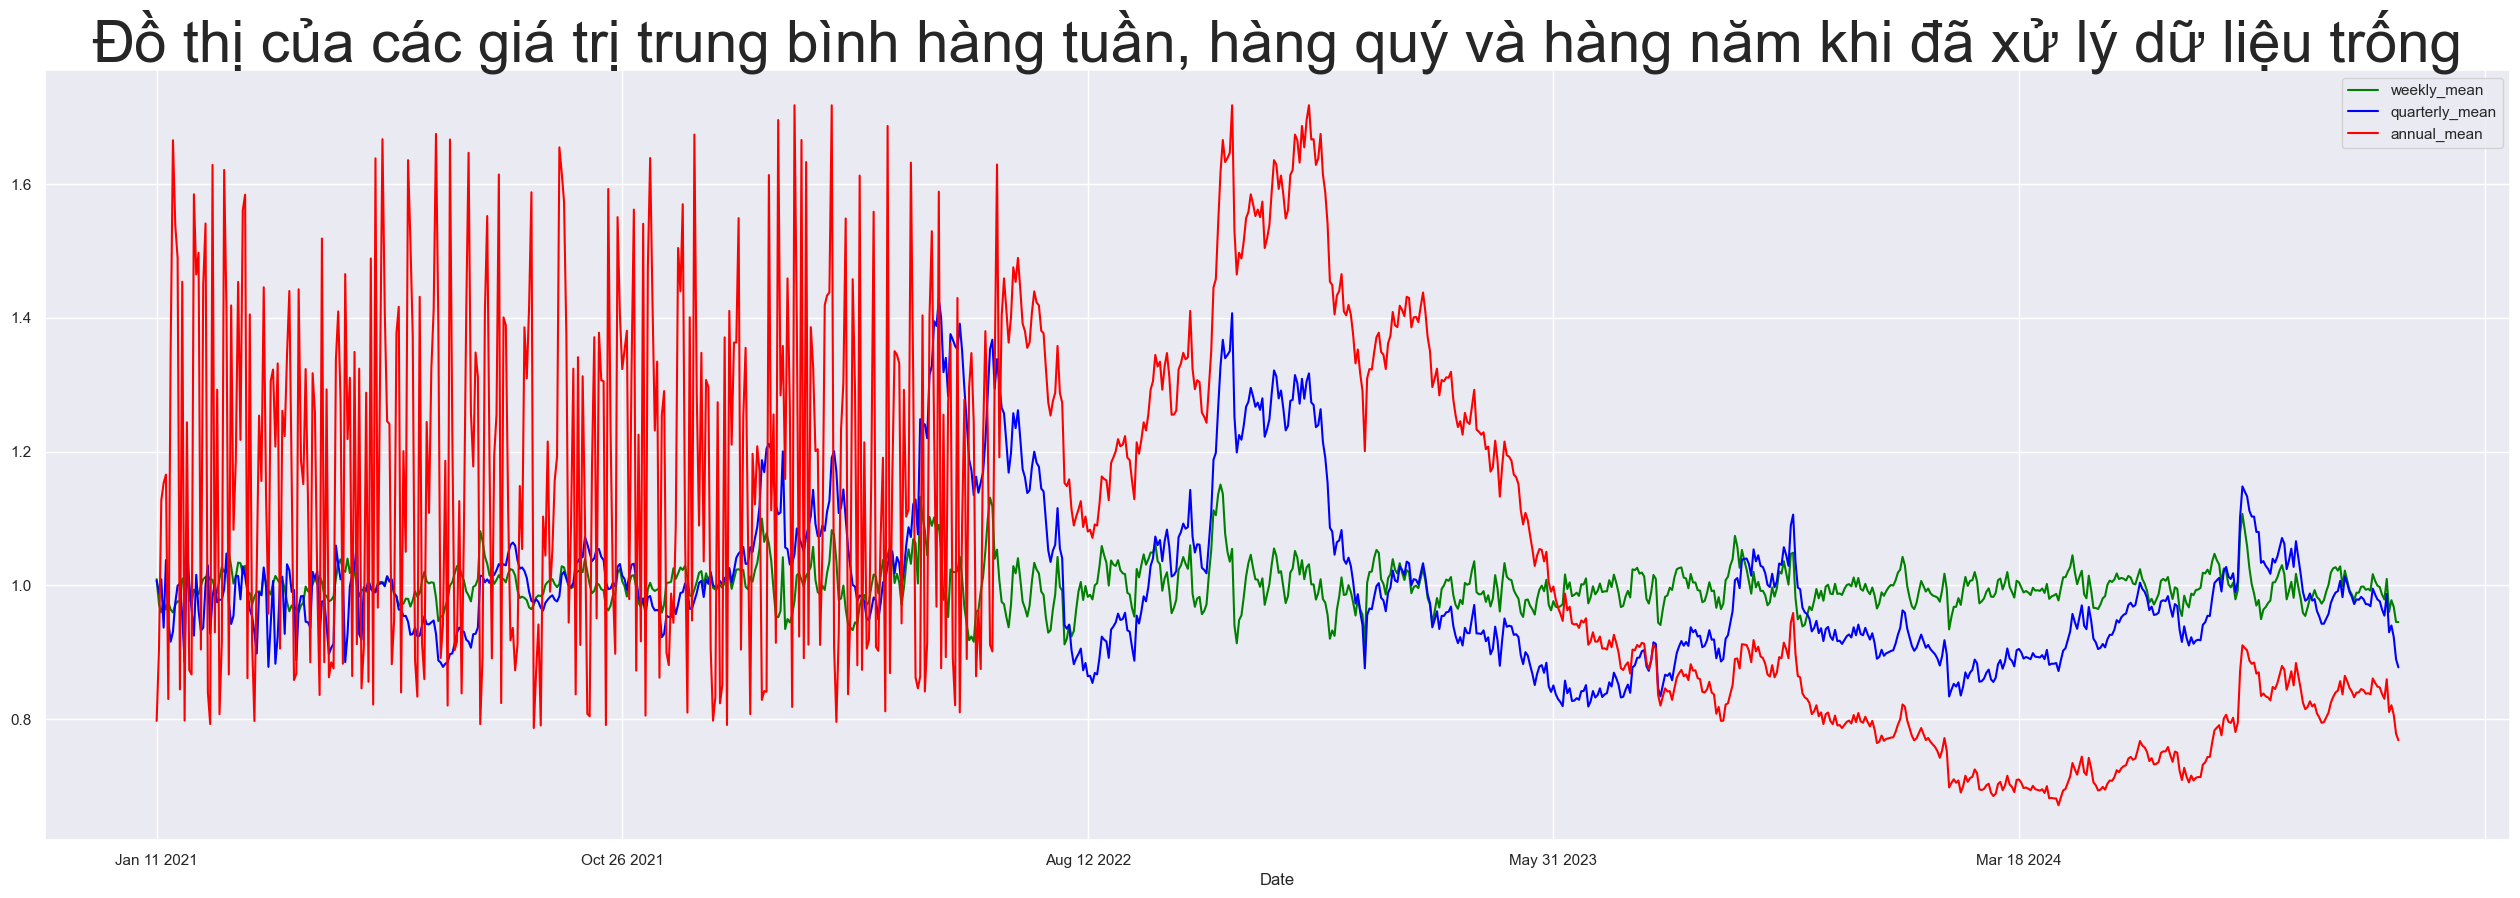

In [45]:
plt.figure(figsize=(70,10))
ax1 = plt.subplot(1, 2, 1)
data.plot.line(x='Date', y='weekly_mean', ax = ax1, color='green', label='weekly_mean')
data.plot.line(x='Date', y='quarterly_mean',ax = ax1, color='blue', label='quarterly_mean')
data.plot.line(x='Date', y='annual_mean',ax = ax1, color='red', label='annual_mean')
plt.title("Đồ thị của các giá trị trung bình hàng tuần, hàng quý và hàng năm khi đã xử lý dữ liệu trống", fontsize=42)

### Mô hình hoá dữ liệu

    Dữ liệu dùng để dự đoán

In [46]:
predictors = ['Open', 'High', 'Low', 'Close', 'Volume']
full_predictors = predictors + ['Have_Increase','weekly_mean', 'quarterly_mean', 'annual_mean', 'open_close_ratio', 'high_close_ratio', 'low_close_ratio']

    Logistic Regression

    Lựa chọn siêu tham số

In [47]:
def Select_Hyperparameters_LogisticRegression(X_train, y_train):
    model = LogisticRegression()

    space = dict()
    space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
    space['penalty'] = ['none', 'l1', 'l2', 'elasticnet']
    space['C'] = loguniform(1e-5, 100)

    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    search = RandomizedSearchCV(model, space, n_iter=500, scoring='accuracy', n_jobs=-1, cv=cv, random_state=1)
    result = search.fit(X_train, y_train)

    return result.best_params_


    Đánh giá độ chính xác

In [48]:
def LogisticRegression_Hyperparameter(X_train, y_train,X_test,y_test, params):
    model = LogisticRegression(C = params['C'], solver = params['solver'], penalty = params['penalty'])
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    cm=confusion_matrix(y_test,y_pred)
    conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
    plt.figure(figsize = (8,5))
    sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")
    return accuracy_score(y_test, y_pred)



    Dùng các đặc trưng mặc định mô hình Logistic

In [49]:
X_train, X_test, y_train, y_test = train_test_split(data[predictors], data['Target'],test_size=0.2, random_state = 5)

In [50]:
best_params_= Select_Hyperparameters_LogisticRegression(X_train, y_train)
print('Siêu tham số cho ra kết quả tốt nhất dùng:',best_params_)

Siêu tham số cho ra kết quả tốt nhất dùng: {'C': np.float64(4.9113831141180554e-05), 'penalty': 'l2', 'solver': 'newton-cg'}


Độ chính xác của thuật toán Logistic Regression với cấu hình siêu tham số và đặc trưng mặc định :   45.08 %


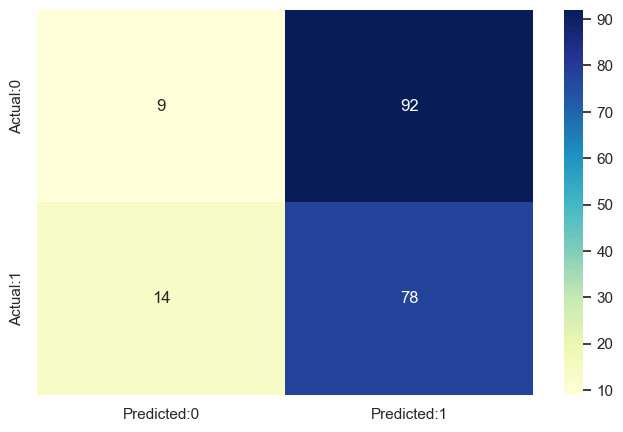

In [51]:
result_logistic = round(LogisticRegression_Hyperparameter(X_train, y_train,X_test,y_test,best_params_),4)
print("Độ chính xác của thuật toán Logistic Regression với cấu hình siêu tham số và đặc trưng mặc định :  ", result_logistic*100,'%')

    Dùng thêm các đặc trưng mới

In [52]:
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(data[full_predictors], data['Target'],test_size=0.2, random_state = 5)

In [53]:
best_params_new= Select_Hyperparameters_LogisticRegression(X_train_new, y_train_new)
print('Siêu tham số cho ra kết quả tốt nhất dùng:',best_params_new)

Siêu tham số cho ra kết quả tốt nhất dùng: {'C': np.float64(3.223866243239877), 'penalty': 'l1', 'solver': 'liblinear'}


Độ chính xác của thuật toán Logistic Regression với cấu hình siêu tham số và đặc trưng mới : 51.300000000000004 %


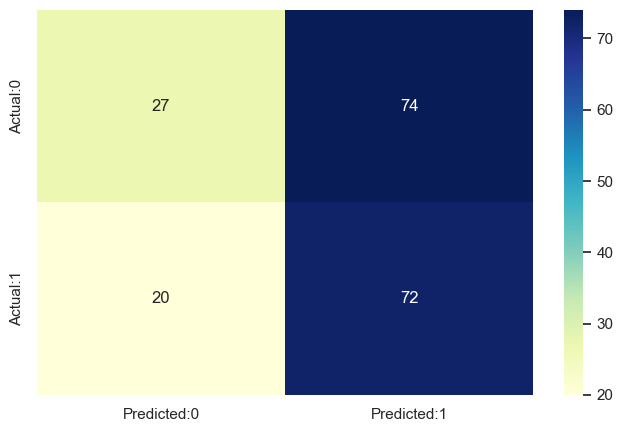

In [54]:
result_logistic_new = round(LogisticRegression_Hyperparameter(X_train_new, y_train_new,X_test_new,y_test_new,best_params_new),4)
print("Độ chính xác của thuật toán Logistic Regression với cấu hình siêu tham số và đặc trưng mới :", result_logistic_new*100,'%')

Với mô hình Logistic Regression thì kết quả có xu hướng dự đoán ra 1 nhiều hơn so với kết quả thật

    Sự chênh lệch về độ chính xác dự đoán giữa dữ liệu được thêm các đặc trưng mới so với dữ liệu cũ

In [55]:
print("Độ chênh lệch giữa có đặc trưng mới và không có:",round((result_logistic_new-result_logistic)*100,2),"%")

Độ chênh lệch giữa có đặc trưng mới và không có: 6.22 %


    Random Forest

    Lựa chọn siêu tham số

In [56]:
def Select_Hyperparameters_RandomForest(X_train_new, y_train_new):
        model = RandomForestClassifier()

        space = dict()
        space['n_estimators'] = [10, 100, 1000]
        space['max_features'] = ['sqrt', 'log2']

        cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
        search = RandomizedSearchCV(model, space, n_iter=500, scoring='accuracy', n_jobs=-1, cv=cv, random_state=1)
        result = search.fit(X_train_new, y_train_new)

        return result.best_params_

best_params_random_1 = Select_Hyperparameters_RandomForest(X_train, y_train)
best_params_random= Select_Hyperparameters_RandomForest(X_train_new, y_train_new)
print('Siêu tham số cho ra kết quả tốt nhất dùng mới:',best_params_random)
print('Siêu tham số cho ra kết quả tốt nhất dùng:',best_params_random_1)

Siêu tham số cho ra kết quả tốt nhất dùng mới: {'n_estimators': 10, 'max_features': 'log2'}
Siêu tham số cho ra kết quả tốt nhất dùng: {'n_estimators': 10, 'max_features': 'log2'}


    Đánh giá độ chính xác

Độ chính xác của thuật toán Random Forest với cấu hình siêu tham số :   48.699999999999996 %
Độ chính xác của thuật toán Random Forest với cấu hình siêu tham số mới :   47.15 %


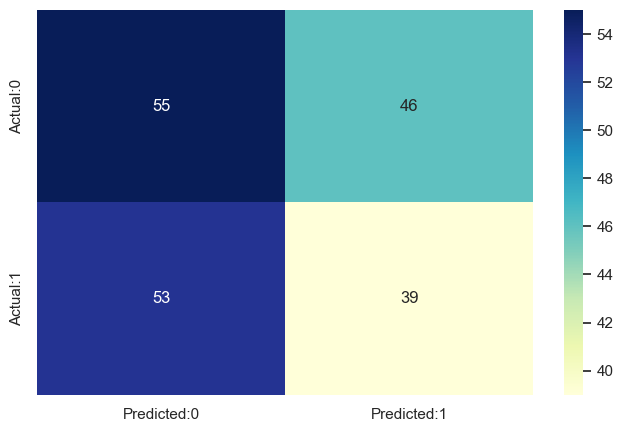

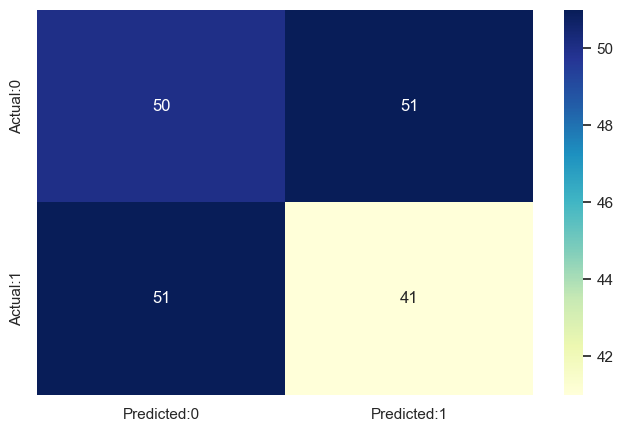

In [57]:
def RandomForest_Hyperparameter(X_train_new, y_train_new,X_test_new,y_test_new,best_params_random):
    model = RandomForestClassifier(n_estimators=best_params_random['n_estimators'], max_features=best_params_random['max_features'])
    model.fit(X_train_new, y_train_new)
    y_pred_new = model.predict(X_test_new)
    cm=confusion_matrix(y_test_new,y_pred_new)
    conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
    plt.figure(figsize = (8,5))
    sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")
    return accuracy_score(y_test_new, y_pred_new)

result_random=round(RandomForest_Hyperparameter(X_train, y_train,X_test,y_test,best_params_random_1),4)
result_random_new=round(RandomForest_Hyperparameter(X_train_new, y_train_new,X_test_new,y_test_new,best_params_random),4)
print("Độ chính xác của thuật toán Random Forest với cấu hình siêu tham số :  ", result_random*100,'%')
print("Độ chính xác của thuật toán Random Forest với cấu hình siêu tham số mới :  ", result_random_new*100,'%')

    Với mô hình Random Forest thì mô hình dự đoán ra kết quả 0 chính xác nhiều hơn nhưng dự đoán kết quả ra 1 lại không chính xác bằng Logistic Regression

In [58]:
print("Độ chênh lệch giữa 2 mô hình Logistic và Random Forest:",round((result_logistic-result_random)*100,2),"%")

Độ chênh lệch giữa 2 mô hình Logistic và Random Forest: -3.62 %


In [59]:
print("Độ chênh lệch giữa 2 mô hình Logistic và Random Forest:",round((result_logistic_new-result_random_new)*100,2),"%")

Độ chênh lệch giữa 2 mô hình Logistic và Random Forest: 4.15 %


    TỔNG KẾT

+ Các đặc trưng mới giúp cải thiện độ chính xác của mô hình 1 cách đáng kể.

+ Mô hình Logistic có kết quả dự đoán tốt hơn so với mô hình Random Forest đối với bài toán này.

+ Việc dự đoán có thể giúp ta dự đoán giá của cổ phiếu trong thời gian tương lai nhưng chỉ ở mức độ từ 53 - 56%.